# Analyse Nanostring data in Napari-SpatialData 


This tutorial shows how to load and analyse Nanostring data with the Napari-SpatialData plugin.


## Import packages and data

There are two options to install napari-spatialdata:

(1) Run `pip install napari-spatialdata`

or, 

(2) Clone this [repo](https://github.com/scverse/napari-spatialdata) and run `pip install -e .`

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
from napari_spatialdata import Interactive
from spatialdata import SpatialData
import squidpy as sq
import scanpy as sc

plt.rcParams['figure.figsize'] = (20, 20)

Next, we will download the Nanostring dataset (cosmx_io) for analysis. Uncomment the lines below to download the dataset. 

In [2]:
# !mkdir tutorial_data
# !mkdir tutorial_data/nanostring_data
# !wget -P tutorial_data/nanostring_data https://s3.embl.de/spatialdata/spatialdata-sandbox/cosmx_io.zip
# !tar -xzf tutorial_data/nanostring_data/cosmx_io.zip -C tutorial_data/nanostring_data/.

--2023-05-03 21:11:58--  https://s3.embl.de/spatialdata/spatialdata-sandbox/cosmx_io.zip
Resolving s3.embl.de (s3.embl.de)... 194.94.45.80
Connecting to s3.embl.de (s3.embl.de)|194.94.45.80|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2210531049 (2,1G) [application/zip]
Saving to: ‘tutorial_data/nanostring_data/cosmx_io.zip’

cosmx_io.zip        100%[===================>]   2,06G  10,9MB/s    in 3m 21s  

2023-05-03 21:15:19 (10,5 MB/s) - ‘tutorial_data/nanostring_data/cosmx_io.zip’ saved [2210531049/2210531049]



We will load the dataset from the filepath and create a {class}`spatialdata.SpatialData` object. We'll use this object with the class `Interactive` to visualise this dataset in Napari.

In [35]:
sdata = SpatialData.read("tutorial_data/nanostring_data/data.zarr")

## Visualise in napari

To make it easier to analyse our data, we will filter the SpatialData object by the coordinate system "1".

In [22]:
sdata = sdata.filter_by_coordinate_system("1")
adata = sdata.table

Then, we make the variable names unique using the method `anndata.var_names_make_unique`. We obtain the mitochondrial genes using their names prefixed with “mt-”. We calculate the quality control metrics on the anndata.AnnData using `scanpy.pp.calculate_qc_metrics`.

In [23]:
adata.var_names_make_unique()
adata.var["mt"] = adata.var_names.str.startswith("mt-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

The `scikit-misc package` could be required for highly variable genes identification.

In [ ]:
# !pip install scikit-misc

Annotate the highly variable genes based on the count data by using `scanpy.pp.highly_variable_genes` with flavor="seurat_v3". Normalize counts per cell using `scanpy.pp.normalize_total`.

Logarithmize, do principal component analysis, compute a neighborhood graph of the observations using `scanpy.pp.log1p`, `scanpy.pp.pca` and `scanpy.pp.neighbors` respectively.

Use `scanpy.tl.umap` to embed the neighborhood graph of the data and cluster the cells into subgroups employing `scanpy.tl.leiden`.

In [24]:
adata.layers["counts"] = adata.X.copy()
sc.pp.highly_variable_genes(adata, flavor="seurat_v3", n_top_genes=4000)
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)
sc.tl.leiden(adata)

/opt/homebrew/lib/python3.9/site-packages/scanpy/preprocessing/_normalization.py:197: UserWarning: Some cells have zero counts
  warn(UserWarning('Some cells have zero counts'))


Next, we will use the Scatter Widget offered by Napari SpatialData to visualise the UMAP coordinates.

First, we instantiate the `Interactive` class with our {class}`spatialdata.SpatialData` object, and view it in Napari.

In [25]:
interactive = Interactive(sdata)
interactive.run()

(-0.5, 2939.5, 1665.5, -0.5)

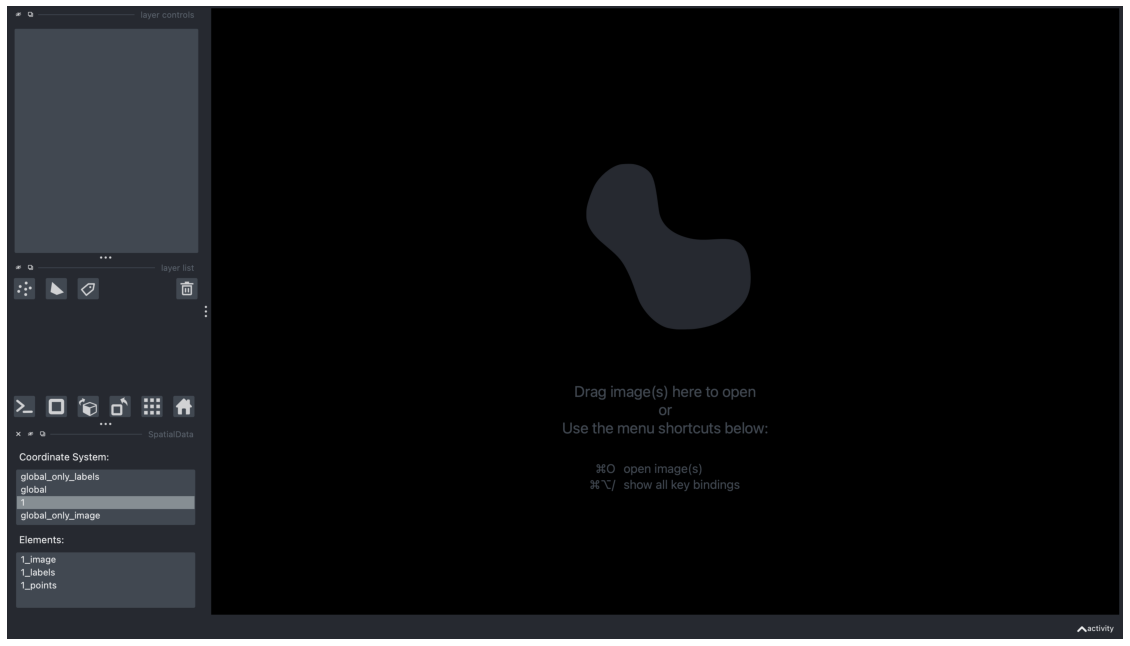

/Users/rahulbshrestha/projects/napari-spatialdata/src/napari_spatialdata/_view.py:107: FutureWarning: Private attribute access ('Selection._current') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  layer = self._viewer.layers.selection._current
Traceback (most recent call last):
  File "/opt/homebrew/lib/python3.9/site-packages/napari/_qt/menus/plugins_menu.py", line 99, in _add_toggle_widget
    self._win.add_plugin_dock_widget(*key)
  File "/opt/homebrew/lib/python3.9/site-packages/napari/_qt/qt_main_window.py", line 717, in add_plugin_dock_widget
    wdg = _instantiate_dock_widget(
  File "/opt/homebrew/lib/python3.9/site-packages/napari/_qt/qt_main_window.py", line 1364, in _instantiate_dock_widget
    return wdg_cls(**kwargs)
  File "/Users/rahulbshrestha/projects/napari-spatialdata/src/napari_spatialdata/_view.py", line 46, in __init__
    self._select_layer()
  File "/Users/rahulbshrestha/projects/napari-spati

In [26]:
plt.imshow(interactive.screenshot())
plt.axis('off')

We select the coordinate system "1" and load the elements "1_image" and "1_labels" into the viewer.

(-0.5, 2939.5, 1665.5, -0.5)

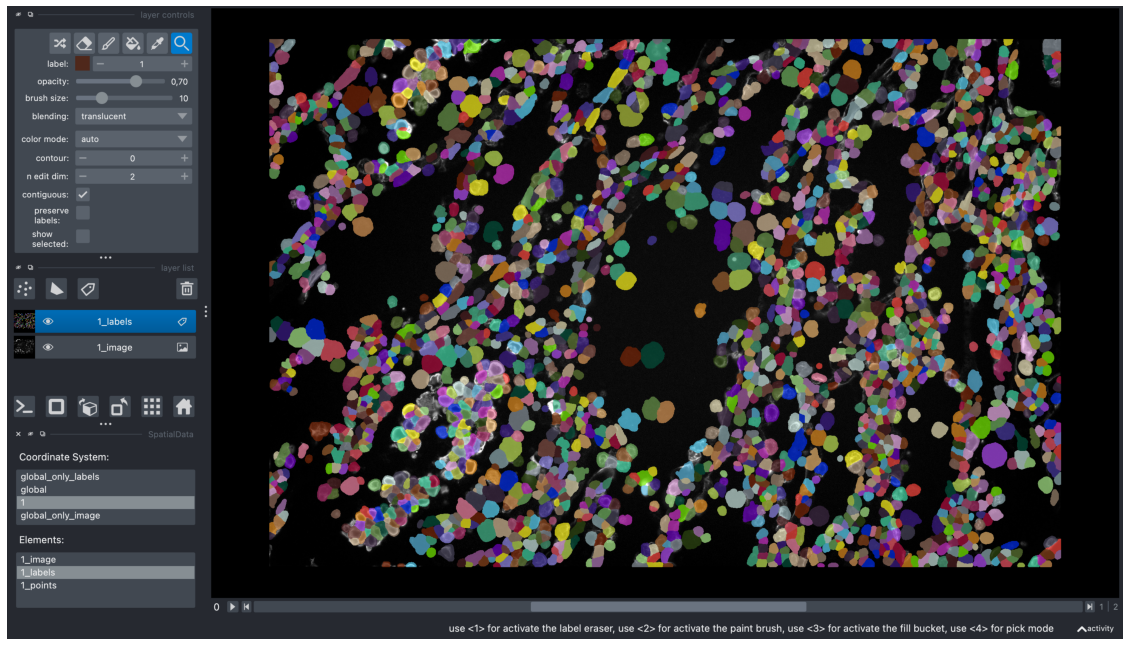

/Users/rahulbshrestha/projects/napari-spatialdata/src/napari_spatialdata/_view.py:107: FutureWarning: Private attribute access ('Selection._current') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  layer = self._viewer.layers.selection._current


In [28]:
plt.imshow(interactive.screenshot())
plt.axis('off')

Select "1_labels" in the list of layers. Then, we open the "Scatter" Widget by using the menu bar and going to Plugins > napari-spatialdata > Scatter. This loads the AnnData object associated with that layer into the "Scatter" Widget.

(-0.5, 2939.5, 1665.5, -0.5)

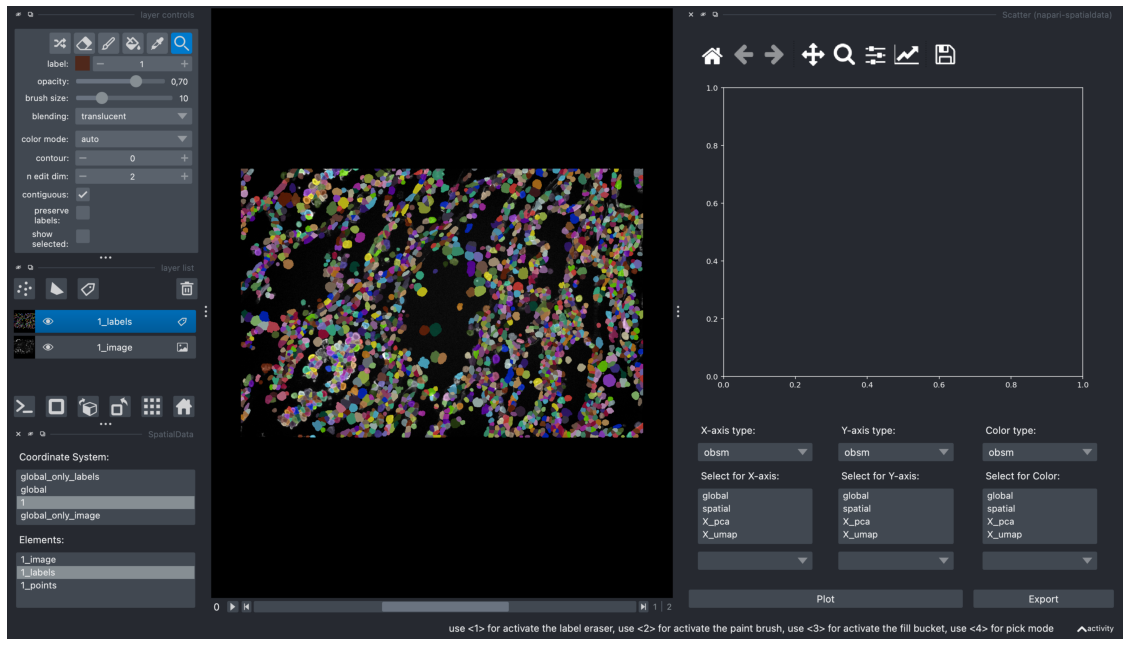

/opt/homebrew/lib/python3.9/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
2023-05-03 21:32:37.378 | DEBUG    | napari_spatialdata._utils:_get_categorical:132 - KEY: leiden
2023-05-03 21:32:38.395 | INFO     | napari_spatialdata._scatterwidgets:plot:253 - Plotting coordinates.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to speci

In [29]:
plt.imshow(interactive.screenshot())
plt.axis('off')

Then, as previously, we can now pick specific x-axis, y-axis and color values to visualise in the scatterplot. In the example below, we're visualising the UMAP (Uniform Manifold Approximation and Projection) coordinates of two different axes and coloring it with clusters created using the Leiden algorithm.

(-0.5, 2939.5, 1665.5, -0.5)

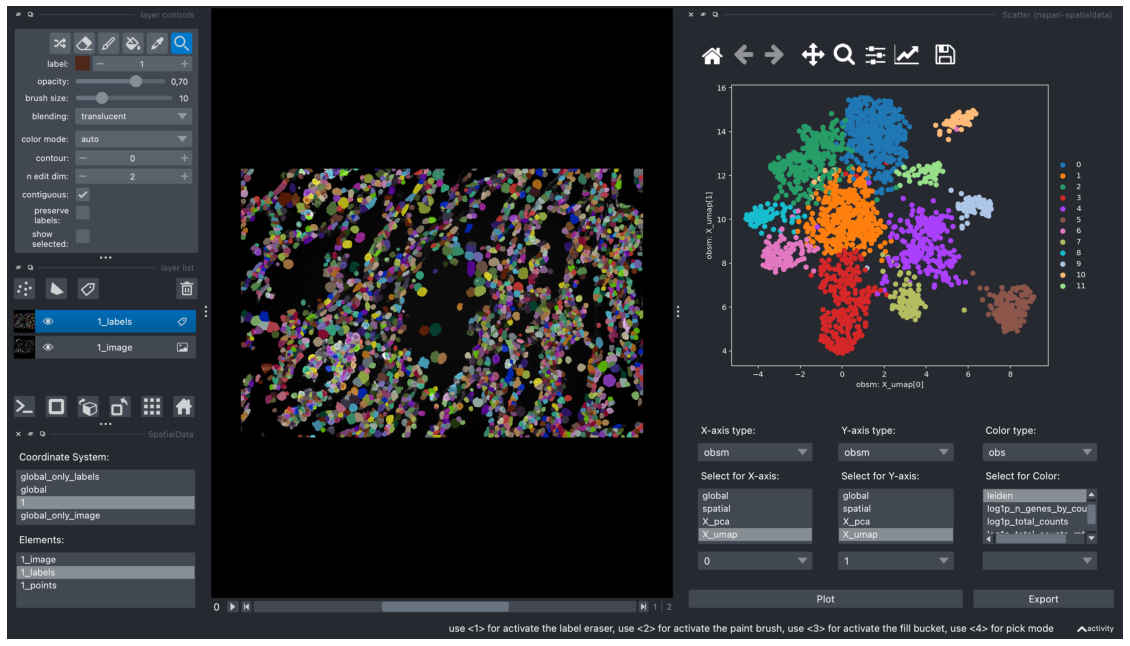

In [30]:
plt.imshow(interactive.screenshot())
plt.axis('off')

After plotting, as mentioned in the previous sections, it is possible to interactively select clusters and export it to AnnData.

In the example below, we used the cursor to select the right top cluster (value of 10). We can export it into AnnData by clicking on the "Export" button.

(-0.5, 2939.5, 1665.5, -0.5)

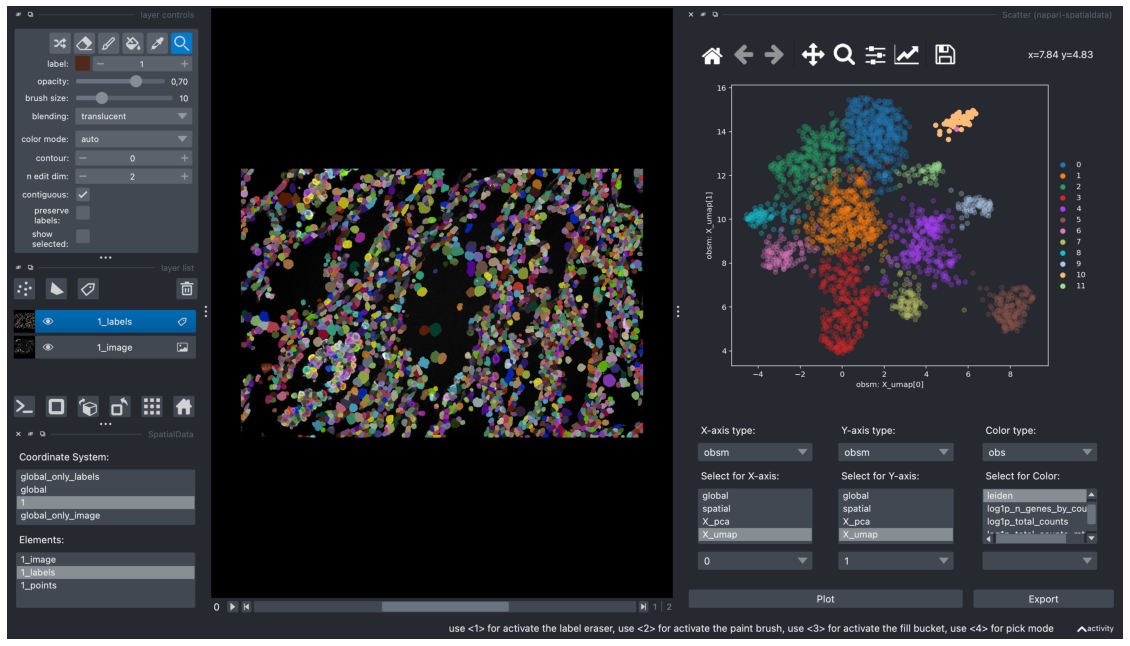

2023-05-03 21:33:08.702 | INFO     | napari_spatialdata._scatterwidgets:export:97 - Exported selected coordinates to obs in AnnData as: 1_labels_LASSO_SELECTED
/Users/rahulbshrestha/projects/napari-spatialdata/src/napari_spatialdata/_view.py:216: FutureWarning: Private attribute access ('Selection._current') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  layer = self._viewer.layers.selection._current


In [31]:
plt.imshow(interactive.screenshot())
plt.axis('off')

We can now view the selected points with the View widget. Close the Scatter Widget and from the menu bar, go to Plugins > napari-spatialdata > View. You should be able to observe "1_labels_LASSO_SELECTED" under "Observations:". This is selected points we exported in the previous step.

(-0.5, 2939.5, 1857.5, -0.5)

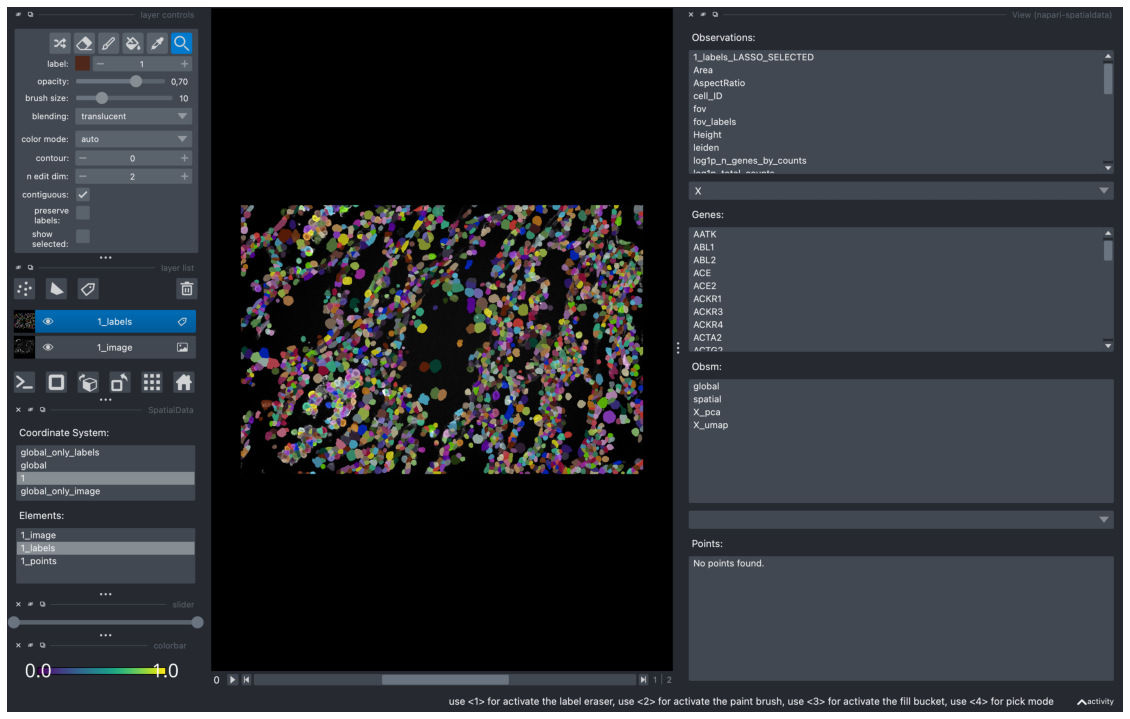

2023-05-03 21:33:25.614 | DEBUG    | napari_spatialdata._utils:_get_categorical:132 - KEY: 1_labels_LASSO_SELECTED
2023-05-03 21:33:27.194 | INFO     | napari_spatialdata._view:_on_layer_update:204 - Updating layer.
/Users/rahulbshrestha/projects/napari-spatialdata/src/napari_spatialdata/_view.py:216: FutureWarning: Private attribute access ('Selection._current') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  layer = self._viewer.layers.selection._current
2023-05-03 21:33:27.207 | INFO     | napari_spatialdata._view:_on_layer_update:204 - Updating layer.
/Users/rahulbshrestha/projects/napari-spatialdata/src/napari_spatialdata/_view.py:107: FutureWarning: Private attribute access ('Selection._current') in this context (e.g. inside a plugin widget or dock widget) is deprecated and will be unavailable in version 0.5.0
  layer = self._viewer.layers.selection._current
2023-05-03 21:33:27.246 | INFO     | napari_spatialda

In [32]:
plt.imshow(interactive.screenshot())
plt.axis('off')

Double clicking on "1_labels_LASSO_SELECTED" loads it as a layer in the Napari viewer.

(-0.5, 2939.5, 1857.5, -0.5)

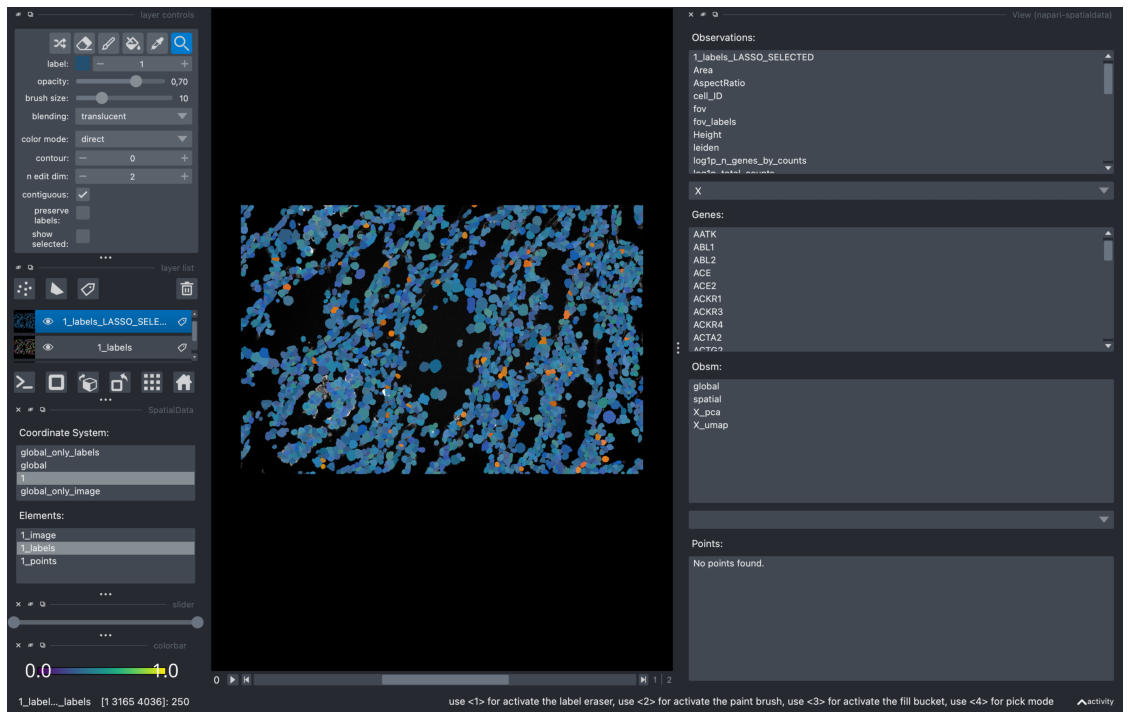

In [33]:
plt.imshow(interactive.screenshot())
plt.axis('off')